In [57]:
import numpy as np
from scipy.stats import pearsonr
import os
from PIL import Image
from scipy.stats import pearsonr
import cv2
import matplotlib.pyplot as plt

In [58]:
def calcular_correlacion(imagen):
    alto, ancho = imagen.shape

    # Dividir la imagen en mitades
    mitad_izquierda = imagen[:, :ancho // 2]
    mitad_derecha = imagen[:, ancho // 2:]

    # Calcular la correlación de Pearson entre las dos mitades
    correlacion, _ = pearsonr(mitad_izquierda.flatten(), mitad_derecha.flatten())

    return correlacion

In [59]:
def operaciones(carpeta):
    lista_archivos = os.listdir(carpeta)

    array_datos = []

    # Recorrer todos los archivos en la carpeta
    for archivo in lista_archivos:
        # Verificar si es un archivo de imagen
        if archivo.endswith(".jpg") or archivo.endswith(".png"):
            # Ruta completa de la imagen
            ruta_imagen = os.path.join(carpeta, archivo)
            
            # Abrir la imagen y convertirla a escala de grises
            imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
            imagen = cv2.normalize(imagen, None, 0, 255, cv2.NORM_MINMAX)

        # Eliminación de ruido con filtrado de media
            imagen = cv2.medianBlur(imagen, 5)

            # Mejora de la nitidez utilizando filtrado bilateral
            imagen = cv2.bilateralFilter(imagen, 9, 75, 75)

            # Calcular la correlación entre las mitades de la imagen
            correlacion = calcular_correlacion(imagen)
            
            # Imprimir el nombre del archivo y la correlación
            print("Archivo:", archivo)
            print("Correlación:", correlacion)
            print("-------------------------------------")
            
            array_datos.append(correlacion)

    array_datos = np.array(array_datos)
    return array_datos


In [62]:
def datos(array):
    promedio = np.mean(array)
    varianza = np.var(array)
    desviacion_estandar = np.std(array)
    umbral_superior = promedio + 2 * desviacion_estandar
    umbral_inferior = promedio - 2 * desviacion_estandar

    # Identificar los datos anormales
    datos_anormales = array[(array > umbral_superior) | (array < umbral_inferior)]

    # Imprimir los datos anormales
    print("Datos anormales:", datos_anormales)
    # Imprimir los resultados
    print("Promedio:", promedio)
    print("Varianza:", varianza)

    # Crear los índices para las barras
    indices = np.arange(len(array))

    # Graficar el np.array en forma de barras
    plt.bar(indices, array)
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.title("Gráfico de barras de los datos")
    plt.show()

Archivo: N1.jpg
Correlación: -0.2986803634198201
-------------------------------------
Archivo: N10.jpg
Correlación: 0.09676896497559008
-------------------------------------
Archivo: N11.jpg
Correlación: -0.19944601972754705
-------------------------------------
Archivo: N12.jpg
Correlación: -0.033904337750584705
-------------------------------------
Archivo: N13.jpg
Correlación: -0.2734794788329886
-------------------------------------
Archivo: N14.jpg
Correlación: 0.11123878315259327
-------------------------------------
Archivo: N15.jpg
Correlación: 0.08143666256464462
-------------------------------------
Archivo: N16.jpg
Correlación: 0.07155427986957806
-------------------------------------
Archivo: N17.jpg
Correlación: 0.1266290863145752
-------------------------------------
Archivo: N18.jpg
Correlación: 0.32811422800817375
-------------------------------------
Archivo: N19.jpg
Correlación: 0.05407177369931803
-------------------------------------
Archivo: N2.jpg
Correlación: -0

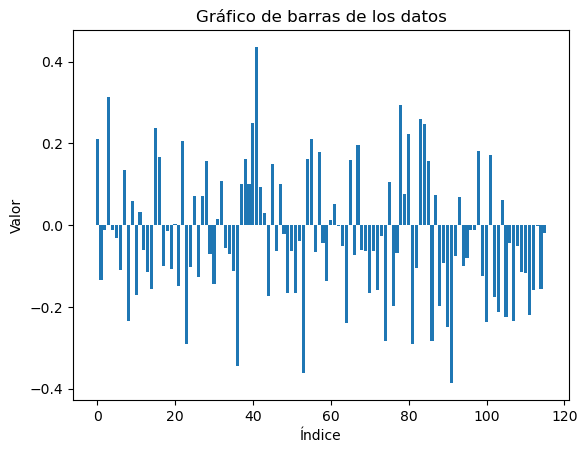

Datos anormales: [ 0.32811423 -0.53344451  0.27584512]
Promedio: -0.044177706313956754
Varianza: 0.024117138804186852


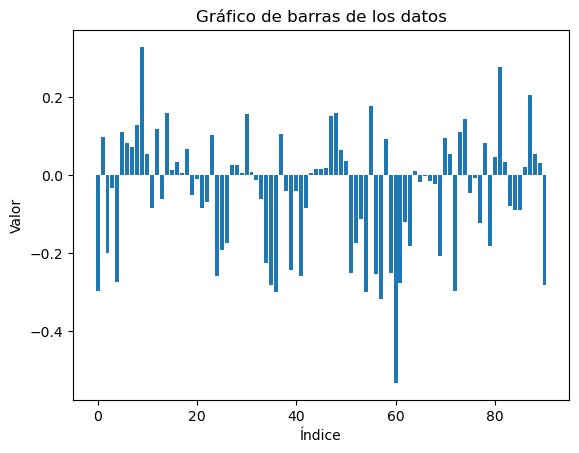

In [63]:
arrayNo = operaciones('no_nuevo/')
arrayYes = operaciones('yes_nuevo/')

datos(arrayYes)
datos(arrayNo)

In [83]:
def sacarDiferencia(carpeta, newCarpeta):
    # Crear la carpeta de imágenes de diferencia si no existe
    if not os.path.exists(newCarpeta):
        os.makedirs(newCarpeta)

    # Obtener la lista de archivos en la carpeta
    archivos = os.listdir(carpeta)

    # Iterar sobre los archivos
    for archivo in archivos:
        # Comprobar si es un archivo de imagen
        if archivo.endswith(".jpg") or archivo.endswith(".png"):
            # Ruta completa de la imagen
            ruta_imagen = os.path.join(carpeta, archivo)

            # Cargar la imagen
            imagen = cv2.imread(ruta_imagen, 0)
            imagen = cv2.normalize(imagen, None, 0, 255, cv2.NORM_MINMAX)

            # Eliminación de ruido con filtrado de media
            imagen = cv2.medianBlur(imagen, 5)

            # Mejora de la nitidez utilizando filtrado bilateral
            imagen = cv2.bilateralFilter(imagen, 9, 75, 75)

            # Obtener dimensiones de la imagen
            alto, ancho = imagen.shape

            # Dividir la imagen en mitades
            mitad_izquierda = imagen[:, :ancho // 2]
            mitad_derecha = imagen[:, ancho // 2:]

            # Aplicar efecto espejo vertical a la mitad derecha
            mitad_derecha_espejo = cv2.flip(mitad_derecha, 1)

            # Calcular la diferencia entre las mitades izquierda y derecha
            # diferencia = cv2.subtract(mitad_izquierda, mitad_derecha_espejo)
            diferencia = np.abs(mitad_izquierda.astype(int) - mitad_derecha_espejo.astype(int))

            # Convertir la imagen de diferencia a CV_8U
            diferencia = cv2.convertScaleAbs(diferencia)

            d = 3
            sigmaColor = 200
            sigmaSpace = 1000

            # Aplicar el filtro bilateral
            diferencia = cv2.bilateralFilter(diferencia, d, sigmaColor, sigmaSpace)

            # Guardar la imagen de diferencia en escala de grises
            nombre_grafica = "mitad_" + archivo
            ruta_grafica = os.path.join(newCarpeta, nombre_grafica)
            cv2.imwrite(ruta_grafica, diferencia)


In [84]:
def vectorizar (carpeta, label):
    archivos = os.listdir(carpeta)

    # Lista para almacenar los vectores de las imágenes
    vectores_imagenes = []

    # Iterar sobre los archivos
    for archivo in archivos:
        # Comprobar si es un archivo de imagen
        if archivo.endswith(".jpg") or archivo.endswith(".png"):
            # Ruta completa de la imagen
            ruta_imagen = os.path.join(carpeta, archivo)
            
            # Cargar la imagen
            imagen = Image.open(ruta_imagen)

            # Redimensiona la imagen a 8x8 píxeles
            imagen = imagen.resize((50, 125))

            # Convierte la imagen a escala de grises
            imagen = imagen.convert("L")

            # Convierte la imagen a un array de NumPy
            array_imagen = np.array(imagen)

            # Aplana el array de imagen a un vector de 1x64
            vector = array_imagen.flatten()

            # Agrega el valor al final del vector
            vector_con_valor = np.append(vector, label)

            # Agrega el vector a la lista de vectores de imágenes
            vectores_imagenes.append(vector_con_valor)

    # Convierte la lista de vectores en una matriz de NumPy
    return np.array(vectores_imagenes)

In [86]:
sacarDiferencia('yes_nuevo/','./carpeta_MitadesYes/')
data_yes = vectorizar('carpeta_MitadesYes/', 1)

sacarDiferencia('no_nuevo/','./carpeta_MitadesNo/')
data_no = vectorizar('carpeta_MitadesNo/', 0)


In [87]:
def divideTrainTest(data, porcentainTrain):
    # Número de filas a seleccionar
    num_filas_seleccionadas = int(porcentainTrain * data.shape[0])

    # Generar índices aleatorios de las filas a seleccionar
    indices_seleccionados = np.random.choice(data.shape[0], num_filas_seleccionadas, replace=False)

    # Crear la matriz con las filas seleccionadas
    Train = data[indices_seleccionados, :]

    # Crear la matriz con las filas no seleccionadas
    indices_no_seleccionados = np.setdiff1d(np.arange(data.shape[0]), indices_seleccionados)
    Test = data[indices_no_seleccionados, :]
    
    return Train, Test
    

In [103]:
data_dividedY = divideTrainTest(data_yes, 0.8)

data_trainY = data_dividedY[0]
data_testY = data_dividedY[1]


data_dividedN = divideTrainTest(data_no, 0.7)

data_trainN = data_dividedN[0]
data_testN = data_dividedN[1]
'''
print(data_yes.shape)
print(data_trainY.shape)
print(data_testY.shape)'''


'\nprint(data_yes.shape)\nprint(data_trainY.shape)\nprint(data_testY.shape)'

In [104]:
def mergeData(data1, data2):
    return np.concatenate((data1, data2), axis=0)

In [105]:
dataTrain = mergeData(data_trainY,data_trainN)
print(dataTrain.shape)
dataTest = mergeData(data_testY,data_testN)
print(dataTest.shape)

(155, 6251)
(52, 6251)


In [106]:
ImgsTrain = dataTrain[:, :6250]
LabelsTtrain = dataTrain[:, 6250]

ImgsTest = dataTest[:, :6250]
LabelsTest = dataTest[: , 6250]

In [107]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for i in range(len(X_test)):
            distances = []
            for j in range(len(self.X_train)):
                dist = euclidean_distance(X_test[i], self.X_train[j])
                distances.append((dist, self.y_train[j]))
            distances.sort(key=lambda x: x[0])  # Ordenar distancias de menor a mayor
            neighbors = distances[:self.k]  # Obtener los k vecinos más cercanos
            classes = [neighbor[1] for neighbor in neighbors]  # Obtener las clases de los vecinos
            y_pred.append(max(set(classes), key=classes.count))  # Clasificación por voto mayoritario
        return y_pred
    

In [115]:
def knnAlgorithm(X_train, Y_train, X_test, Y_test, k):
    clases = np.unique(Y_train)
    confussionMatrix = np.zeros((len(clases),len(clases)), dtype=int)
    knn = KNNClassifier(k)
    knn.fit(X_train, Y_train)
    predictions = knn.predict(X_test)
    for i in range (len(predictions)):
        confussionMatrix[predictions[i]][Y_test[i]] += 1
    #print(confussionMatrix)
    accuracy = np.trace(confussionMatrix)/np.sum(confussionMatrix)
    print("the accuracy with k = ",k, " is ",accuracy)
    #return accuracy

In [116]:
'''for i in range(1,15):
    knnAlgorithm(ImgsTrain, LabelsTtrain, ImgsTest, LabelsTest, i)'''
    
#La mejor es de 1, tomando solo el vecino más cercano
knnAlgorithm(ImgsTrain, LabelsTtrain, ImgsTest, LabelsTest, 1)


the accuracy with k =  1  is  0.8076923076923077


In [147]:
class KMeans:
    def __init__(self, k, max_iterations):
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = None
        self.labels = None

    def initialize_centroids(self, data):
        # Inicialización de centroides de manera aleatoria
        np.random.seed(0)
        indices = np.random.choice(data.shape[0], self.k, replace=False)
        centroids = data[indices]
        return centroids
    
    def initialize_centroids_with_features(self, data, real_labels):
        # Preprocesamiento de las imágenes
        flattened_images = data.reshape(data.shape[0], -1)  # Aplanar las imágenes en vectores de características
        unique_labels = np.unique(real_labels)

        # Cálculo de características promedio por etiqueta
        centroids = []
        for label in unique_labels:
            label_images = flattened_images[real_labels == label]
            label_mean = np.mean(label_images, axis=0)
            centroids.append(label_mean)

        # Selección de los primeros K centroides iniciales
        centroids = np.array(centroids)[:self.k]

        return centroids

    def assign_clusters(self, data):
        # Asignación de puntos a clústeres según la distancia euclidiana
        distances = np.sqrt(((data[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=1)
        return labels

    def update_centroids(self, data):
        # Actualización de los centroides como la media de los puntos asignados a cada clúster
        centroids = np.zeros((self.k, data.shape[1]))
        for i in range(self.k):
            cluster_data = data[self.labels == i]
            if len(cluster_data) > 0:
                centroids[i] = np.mean(cluster_data, axis=0)
        return centroids

    def fitRANDOM(self, data):
        self.centroids = self.initialize_centroids(data)

        for _ in range(self.max_iterations):
            prev_centroids = self.centroids.copy()

            self.labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)

            # Comprobar convergencia
            if np.all(prev_centroids == self.centroids):
                break
            
    def fitPreprocess(self, data, real_labels):
        self.centroids = self.initialize_centroids_with_features(data, real_labels)

        for _ in range(self.max_iterations):
            prev_centroids = self.centroids.copy()

            self.labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)

            # Comprobar convergencia
            if np.all(prev_centroids == self.centroids):
                break

    def predict(self, data):
        labels = self.assign_clusters(data)
        return labels
    
    

In [142]:
def calculate_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, num_classes))
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        confusion_matrix[true_label][predicted_label] += 1
    return confusion_matrix

In [160]:
def compareKmeans(X_train ,Y_train, X_test, Y_test, iterations, k = 2 ):
    kmeansPre = KMeans(k,iterations)
    kmeansR = KMeans(k,iterations)
    # Ajustar el modelo a los datos
    kmeansPre.fitPreprocess(X_train, Y_train)
    kmeansR.fitRANDOM(X_train)
    # Obtener las etiquetas asignadas a cada punto
    predicted_labelsPre = kmeansPre.predict(X_test)
    predicted_labelsR = kmeansR.predict(X_test)
    # Calcular la matriz de confusión
    confusion_matrixPre = calculate_confusion_matrix(Y_test, predicted_labelsPre, num_classes=k)
    confusion_matrixR = calculate_confusion_matrix(Y_test, predicted_labelsR, num_classes=k)
    # Imprimir la matriz de confusión
    '''print("Matriz de Confusión:")
    print(confusion_matrix)'''

    # Calcular la precisión como la suma de las coincidencias diagonales dividida por el número total de puntos
    accuracyPre = np.sum(np.max(confusion_matrixPre, axis=1)) / len(X_test)
    accuracyR = np.sum(np.max(confusion_matrixR, axis=1)) / len(X_test)

    # Imprimir la precisión
    print("Precisión de clasificación con preprocesamiento: {:.2f}%".format(accuracyPre * 100))
    print("Precisión de clasificación con Random: {:.2f}% \n".format(accuracyR * 100))


In [165]:
compareKmeans(ImgsTrain,LabelsTtrain,ImgsTest, LabelsTest, 2)

Precisión de clasificación con preprocesamiento: 71.15%
Precisión de clasificación con Random: 88.46% 

